In [1]:
import pandas as pd
import torch

df = pd.read_csv('KOs_with_labels_for_BERT.csv')
label_to_int_mapping = {label: i for i, label in enumerate(df['label'].unique())}
ko_label_dict = {}
for index, row in df.iterrows():
    ko, label = row['KOs'], row['label']
    if ko not in ko_label_dict:
        ko_label_dict[ko] = label

df['embeddings'] = df['embeddings'].apply(lambda x: (eval("torch."+ x)))
print(df.head(5))

        KOs                       label   
0  K02868.1                    Ribosome  \
1  K02987.1                    Ribosome   
2  K00571.1  Prokaryotic defense system   
3  K02978.1                    Ribosome   
4  K02929.2                    Ribosome   

                                          embeddings  
0  [tensor(0.0025), tensor(-0.0019), tensor(-0.00...  
1  [tensor(0.0116), tensor(0.0071), tensor(-0.006...  
2  [tensor(0.0040), tensor(-0.0005), tensor(-0.01...  
3  [tensor(-0.0004), tensor(-0.0085), tensor(-0.0...  
4  [tensor(0.0011), tensor(-0.0046), tensor(-0.00...  


In [2]:
label_to_int_mapping

{'Ribosome': 0,
 'Prokaryotic defense system': 1,
 'Porphyrin and chlorophyll metabolism': 2,
 'Oxidative phosphorylation': 3,
 'Amino sugar and nucleotide sugar metabolism': 4,
 'Secretion system': 5,
 'Two-component system': 6,
 'Energy metabolism': 7,
 'Benzoate degradation': 8}

In [3]:
X = df['embeddings'].to_numpy()

df['label_int'] = df['label'].map(label_to_int_mapping)
label_int_array = df['label_int'].to_numpy()
print(X.shape, label_int_array.shape)

(5533,) (5533,)


In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import numpy as np

train_X, test_X, train_y, test_y = train_test_split(X, label_int_array, test_size=0.2, random_state=42, stratify=label_int_array)

train_X=np.vstack(train_X)
test_X=np.vstack(test_X)

encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_1hot = encoder.fit_transform(train_y.reshape(-1,1))

print(train_X.shape, test_X.shape, y_1hot.shape, test_y.dtype)


(4426, 512) (1107, 512) (4426, 9) int64


In [5]:
import torch

x_train = torch.tensor(train_X, dtype=torch.float)
x_test = torch.tensor(test_X, dtype=torch.float)
y_train = torch.tensor(y_1hot, dtype=torch.float)
y_test = torch.tensor(test_y, dtype=torch.int64)

In [6]:
import torch
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 512
first_hidden = 256
second_hidden = 128
last_hidden = 64
output_dim = 9
dropout_prob = 0.2

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clf_model.to(device)

Classification_V0(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=9, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [8]:
class Word2vecdataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y      
        self.len = X.shape[0] 

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
    
        X_idx = self.X[idx, :]
        y_idx = self.y[idx]
        return X_idx, y_idx

In [9]:
train_dataset = Word2vecdataset(x_train, y_train)
test_dataset = Word2vecdataset(x_test, y_test)

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(clf_model.parameters())

In [11]:
clf_model.train()
losses = []

for i in range(30):
    loss_epoch = 0
    print(f"Training at {i+1} epoch")
    for index, data in enumerate(train_loader):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = clf_model(X)
        loss = criterion(logits, y)
        loss_epoch+=loss.item()
        loss.backward()
        optimizer.step()
    print("Loss: ",loss_epoch/len(train_loader), end="\n\n")
    losses.append(loss_epoch/len(train_loader))
    
print("Finished training")

Training at 1 epoch
Loss:  1.970937510188535

Training at 2 epoch
Loss:  1.8914542146723905

Training at 3 epoch
Loss:  1.849334955215454

Training at 4 epoch
Loss:  1.809075518477735

Training at 5 epoch
Loss:  1.7493232239922174

Training at 6 epoch
Loss:  1.683067203425675

Training at 7 epoch
Loss:  1.6159252357139862

Training at 8 epoch
Loss:  1.5215346607372915

Training at 9 epoch
Loss:  1.4178294929669057

Training at 10 epoch
Loss:  1.2995990193147453

Training at 11 epoch
Loss:  1.16870103036757

Training at 12 epoch
Loss:  1.0145508659829339

Training at 13 epoch
Loss:  0.912885672754521

Training at 14 epoch
Loss:  0.7905646648338372

Training at 15 epoch
Loss:  0.7080855631142211

Training at 16 epoch
Loss:  0.6161614877285717

Training at 17 epoch
Loss:  0.5340506982245892

Training at 18 epoch
Loss:  0.4965961485457935

Training at 19 epoch
Loss:  0.4374893692543181

Training at 20 epoch
Loss:  0.39907926342470185

Training at 21 epoch
Loss:  0.36268118056033155

Traini

In [12]:
# clf_model.eval()
# acc_mean = 0
# all_preds = []
# with torch.inference_mode():
#     for index, data in enumerate(test_loader):
#         X, y = data
#         outputs = clf_model(X.to(device))
#         predictions = torch.argmax(torch.softmax(outputs, dim=-1), dim=1)
#         correct = torch.eq(y, predictions.cpu()).sum().item()
#         all_preds.append(predictions.cpu())
#         acc_mean += (correct / len(y)) * 100
        
#     print("Classification accuracy: ", acc_mean/len(test_loader))

In [13]:
clf_model.eval()
with torch.inference_mode():
    outputs = clf_model(x_test.to(device))
    predictions = torch.argmax(torch.softmax(outputs, dim=-1), dim=1)
    correct = torch.eq(y_test, predictions.cpu()).sum().item()
    print("Number of correct guesses = ", correct)
    print("Number of test samples = ", len(y_test))
    acc = (correct / len(y_test)) * 100
    print("Classification accuracy: ", acc)

Number of correct guesses =  334
Number of test samples =  1107
Classification accuracy:  30.171635049683832


In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions.cpu(), target_names=label_to_int_mapping.keys())
print(report)

                                             precision    recall  f1-score   support

                                   Ribosome       0.19      0.27      0.22        98
                 Prokaryotic defense system       0.28      0.22      0.25       174
       Porphyrin and chlorophyll metabolism       0.29      0.11      0.16        55
                  Oxidative phosphorylation       0.26      0.15      0.19        84
Amino sugar and nucleotide sugar metabolism       0.33      0.13      0.19        62
                           Secretion system       0.39      0.41      0.40       323
                       Two-component system       0.32      0.44      0.37       235
                          Energy metabolism       0.09      0.10      0.09        42
                       Benzoate degradation       0.04      0.03      0.03        34

                                   accuracy                           0.30      1107
                                  macro avg       0.24      0.2

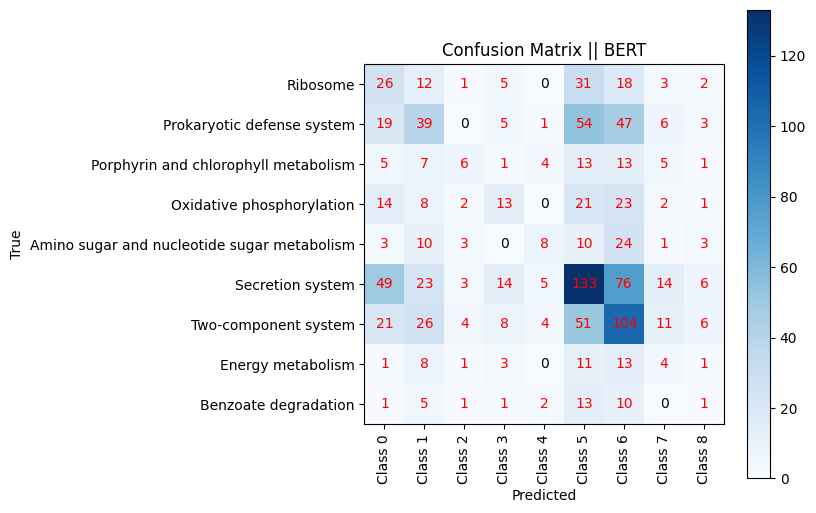

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the tensors to NumPy arrays
y_true = y_test.cpu().numpy()  # Convert to NumPy and move to CPU if using GPU
y_pred = predictions.cpu().numpy()

# Create an empty confusion matrix
confusion_matrix = np.zeros((len(label_to_int_mapping), len(label_to_int_mapping)))

# Fill in the confusion matrix
for i in range(len(y_true)):
    true_class = int(y_true[i])
    pred_class = int(y_pred[i])
    confusion_matrix[true_class, pred_class] += 1

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix || BERT')
plt.colorbar()

tick_marks = np.arange(len(label_to_int_mapping))
plt.xticks(tick_marks, [f'Class {i}' for i in range(len(label_to_int_mapping))], rotation=90)
plt.yticks(tick_marks, list(label_to_int_mapping.keys()))

for i in range(len(label_to_int_mapping)):
    for j in range(len(label_to_int_mapping)):
        plt.text(j, i, f'{int(confusion_matrix[i, j]):d}', ha='center', va='center', color='red' if confusion_matrix[i, j] > 0.5 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("Results/Confmat_BERT.png")
plt.show()



In [17]:
print(torch.sum(y_test == 0).item())
print(torch.sum(y_test == 1).item())
print(torch.sum(y_test == 2).item())
print(torch.sum(y_test == 3).item())
print(torch.sum(y_test == 4).item())
print(torch.sum(y_test == 5).item())
print(torch.sum(y_test == 6).item())
print(torch.sum(y_test == 7).item())
print(torch.sum(y_test == 8).item())

label_to_int_mapping

98
174
55
84
62
323
235
42
34


{'Ribosome': 0,
 'Prokaryotic defense system': 1,
 'Porphyrin and chlorophyll metabolism': 2,
 'Oxidative phosphorylation': 3,
 'Amino sugar and nucleotide sugar metabolism': 4,
 'Secretion system': 5,
 'Two-component system': 6,
 'Energy metabolism': 7,
 'Benzoate degradation': 8}

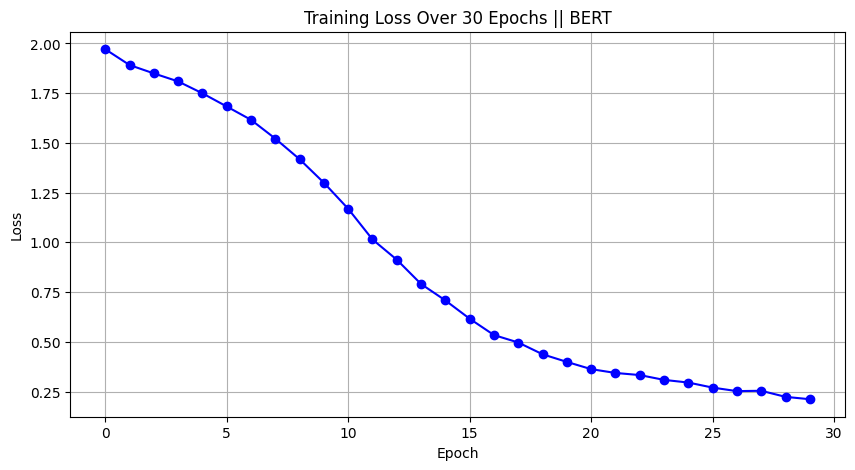

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b')
plt.title(f'Training Loss Over {len(losses)} Epochs || BERT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig("Results/Training_loss_BERT.png")
plt.show()